In [12]:
import numpy as np
import sys
import logging
import concurrent.futures
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from sliderule import sliderule, icesat2, earthdata, h5, ipysliderule, io
import warnings
from IPython import display
import json

warnings.filterwarnings('ignore')

In [31]:
# Select predetermined track
site = "utqiagvik"
#site = "blackrock"

#options
# "len": recommended 20.0
segLength = 20.0
# "res":  recommended 10.0
res = 10.0

In [6]:
# Configure ICESat-2 API
icesat2.init("slideruleearth.io", verbose=False)

In [29]:
#pregion = gpd.read_file(poly_fn)
#poly = sliderule.toregion(pregion)["poly"]

# Read geojson with geopandas
#pregion = gpd.read_file(poly_fn)
#pregion.plot();



In [7]:
'''
File Naming Conventions
ATL[xx]_[yyyymmdd][hhmmss]_[tttt][cc][nn]_[vvv]_[rr].h5
xx : ATLAS product number
yyyymmdd : year, month and day of data acquisition
hhmmss : start time, hour, minute, and second of data acquisition
tttt : Reference Ground Track (RGT, ranges from 1–1387)
cc : Orbital Cycle (91-day period)
nn : Granule number (ranges from 1–14)
vvv : data version number
rr : data release number
'''

# Import granule id, 
def unpackGranuleID(gid):
    global shortName, dat, tim, rgt, cycle, granuleNumber, version, release
    gid = gid.split('_')
    shortName = f'{gid[0]}'
    dat = f'{gid[1][0:4]}-{gid[1][4:6]}-{gid[1][6:8]}'
    tim = f'{gid[1][8:10]}:{gid[1][10:12]}:{gid[1][12:14]}'
    rgt = int(f'{gid[2][0:4]}')
    cycle = int(f'{gid[2][4:6]}')
    granuleNumber = f'{gid[2][6:8]}'
    version = f'{gid[3]}'
    release = f'{gid[4][0:2]}'

In [17]:
# Load JSON data from a file into a Python dictionary
with open('/home/jovyan/surfit/data/icesat2_tracks.json') as json_file:
    data_dict = json.load(json_file)

In [34]:
#Unpack site metadata
pregion = f"/home/jovyan/surfit/data/bbox_{site}.geojson" 
region = sliderule.toregion(pregion)["poly"]
gid = data_dict[site]["granule_id"]
beam = data_dict[site]["beam"]
unpackGranuleID(gid)

In [35]:
# Build ATL06 Request
parms = {
    "poly": region,
    "srt": icesat2.SRT_LAND,
    "cnf": -2,
    "ats": 10.0,
    "cnt": 10,
    "len": segLength,
    "res": res,
    "maxi": 1,
    "cycle": cycle,
}

In [36]:
# Latch Start Time
perf_start = time.perf_counter()

# Request ATL06 Data
atl06_sr = icesat2.atl06p(parms, "nsidc-s3")

# Latch Stop Time
perf_stop = time.perf_counter()

# Display Statistics
perf_duration = perf_stop - perf_start
print("Completed in {:.3f} seconds of wall-clock time".format(perf_duration))
print("Reference Ground Tracks: {}".format(atl06_sr["rgt"].unique()))
print("Cycles: {}".format(atl06_sr["cycle"].unique()))
print("Received {} elevations".format(atl06_sr.shape[0]))

Completed in 11.889 seconds of wall-clock time
Reference Ground Tracks: [ 381  815 1257 1326]
Cycles: [15]
Received 55914 elevations


In [ ]:
atl06_sr

,cycle,rms_misfit,h_mean,pflags,n_fit_photons,distance,rgt,spot,dh_fit_dx,segment_id,w_surface_window_final,gt,h_sigma,dh_fit_dy,geometry
time,,,,,,,,,,,,,,,
2022-04-17 01:15:52.822686208,15,104.095798,6.711406,4,398,1.208686e+07,381,1,1.197411,603405,30.540110,10,5.439221,0.0,POINT (-156.48805 71.56392)
2022-04-17 01:15:52.824097280,15,110.499813,13.706023,4,524,1.208687e+07,381,1,-0.323133,603406,14.416968,10,4.832015,0.0,POINT (-156.48809 71.56383)
2022-04-17 01:15:52.825504000,15,114.105885,14.725704,4,615,1.208688e+07,381,1,-0.261386,603406,15.036317,10,4.613931,0.0,POINT (-156.48813 71.56374)
2022-04-17 01:15:52.826915328,15,109.534093,17.030891,4,652,1.208689e+07,381,1,-0.533503,603406,20.412795,10,4.306992,0.0,POINT (-156.48816 71.56365)
2022-04-17 01:15:52.828324608,15,109.704130,12.229053,4,635,1.208690e+07,381,1,-1.265971,603407,32.288045,10,4.353674,0.0,POINT (-156.48820 71.56356)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-17 22:19:58.634675200,15,189.269256,7.458086,4,462,1.211064e+07,1326,5,4.697677,604598,119.792337,20,8.892139,0.0,POINT (-156.83806 71.35279)
2022-06-17 22:19:58.636069888,15,186.089500,20.966335,4,457,1.211065e+07,1326,5,2.827560,604599,72.105372,20,8.782668,0.0,POINT (-156.83810 71.35270)
2022-06-17 22:19:58.637471488,15,188.092359,14.106846,4,486,1.211066e+07,1326,5,2.566896,604599,65.458706,20,8.538206,0.0,POINT (-156.83814 71.35262)


In [37]:
projection = 'Global'
max_plot_point = atl06_sr.shape[0]
m = ipysliderule.leaflet(projection)
m.GeoData(atl06_sr, column_name='h_mean', cmap='viridis', max_plot_point=max_plot_point)

display.display(m.map)

Map(center=[39, -108], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

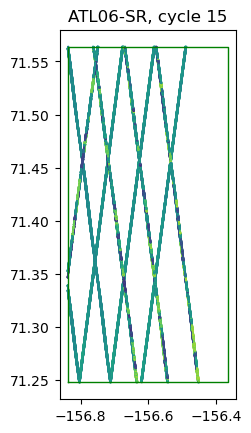

In [40]:
# Prepare coordinate lists for plotting the region of interest polygon
region_lon = [e["lon"] for e in region]
region_lat = [e["lat"] for e in region]

f, ax = plt.subplots()
ax.set_title(f"ATL06-SR, cycle {cycle}")
ax.set_aspect('equal')
atl06_sr.plot(ax=ax, column='h_mean', cmap='viridis', s=0.1)
ax.plot(region_lon, region_lat, linewidth=1, color='g');

In [ ]:
f, ax = plt.subplots()
ax.set_title("ATL06-SR Points")
ax.set_aspect('equal')
atl06_sr.plot(ax=ax, column='h_mean', cmap='viridis', s=0.1)
ax.plot(region_lon, region_lat, linewidth=1, color='red');

## Plot ATL06-SR vs. ATL06

In [128]:
projection = 'Global'
max_plot_point = atl06_sr.shape[0]
m = ipysliderule.leaflet(projection)
m.GeoData(atl06_sr, column_name='h_mean', cmap='viridis', max_plot_point=max_plot_point)

display.display(m.map)

Map(center=[39, -108], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [17]:
# Works to subset selected gt (60) and newest cycle (17)
cycleChoice = 17
gtChoice = ''
rgtChoice = ''#622
#syntax for gt is weird because it is not an attribute of GDFs
df_subset = atl06_sr[(atl06_sr.cycle == cycleChoice)*atl06_sr.loc[:, 'gt']==gtChoice]
df_subset.loc[:, ['rgt', 'gt', 'cycle']]

,rgt,gt,cycle
time,,,
